<a href="https://colab.research.google.com/github/ImanFakury/imanRepository/blob/master/DeppLearning%5CCHW3%5CQ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Larning Course
## Assignment3-Q2
### Iman Alizadeh Fakouri(401102134)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")


using cuda device


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load dataset
cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# 'airplane' and 'automobile'
selected_classes = [0, 1]  # 0: airplane, 1: automobile
filtered_indices = [i for i in range(len(cifar10_dataset.targets)) if cifar10_dataset.targets[i] in selected_classes]
filtered_train_dataset = torch.utils.data.Subset(cifar10_dataset, filtered_indices)
filtered_test_indices = [i for i in range(len(cifar10_test_dataset.targets)) if cifar10_test_dataset.targets[i] in selected_classes]
filtered_test_dataset = Subset(cifar10_test_dataset, filtered_test_indices)

batch_size = 256
train_loader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False)

# Check the dataset sizes
print(f"Number of training examples: {len(filtered_train_dataset)}")
print(f"Number of test examples: {len(filtered_test_dataset)}")


100%|██████████| 170M/170M [00:18<00:00, 9.21MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training examples: 10000
Number of test examples: 2000


# Part 1
# Training a linear classifier, fixed feature extractor
This code utilizes transfer learning with a pre-trained ResNet-50 model for binary classification. It modifies the fully connected layer, freezes pre-trained parameters, and trains the model for 20 epochs.

In [ ]:
# Load pre-trained ResNet-50 model
model = models.resnet50(weights='DEFAULT')

# Freeze params
for param in model.parameters():
    param.requires_grad = False

#Designing a new FC layer according to our case
num_ftrs = model.fc.in_features
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
train_accuracies = []
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

Epoch [1/20], Loss: 0.4087, Accuracy: 84.80%
Epoch [2/20], Loss: 0.3723, Accuracy: 85.52%
Epoch [3/20], Loss: 0.3608, Accuracy: 86.29%
Epoch [4/20], Loss: 0.3410, Accuracy: 86.30%
Epoch [5/20], Loss: 0.3409, Accuracy: 86.90%
Epoch [6/20], Loss: 0.3257, Accuracy: 87.44%
Epoch [7/20], Loss: 0.3258, Accuracy: 87.38%
Epoch [8/20], Loss: 0.3190, Accuracy: 87.45%
Epoch [9/20], Loss: 0.3263, Accuracy: 86.96%
Epoch [10/20], Loss: 0.3107, Accuracy: 87.80%
Epoch [11/20], Loss: 0.3151, Accuracy: 87.74%
Epoch [12/20], Loss: 0.3214, Accuracy: 87.61%
Epoch [13/20], Loss: 0.3101, Accuracy: 87.45%
Epoch [14/20], Loss: 0.3039, Accuracy: 87.71%
Epoch [15/20], Loss: 0.2979, Accuracy: 88.13%
Epoch [16/20], Loss: 0.3080, Accuracy: 87.22%
Epoch [17/20], Loss: 0.2960, Accuracy: 88.05%
Epoch [18/20], Loss: 0.3027, Accuracy: 87.93%
Epoch [19/20], Loss: 0.3051, Accuracy: 88.13%
Epoch [20/20], Loss: 0.2971, Accuracy: 87.94%


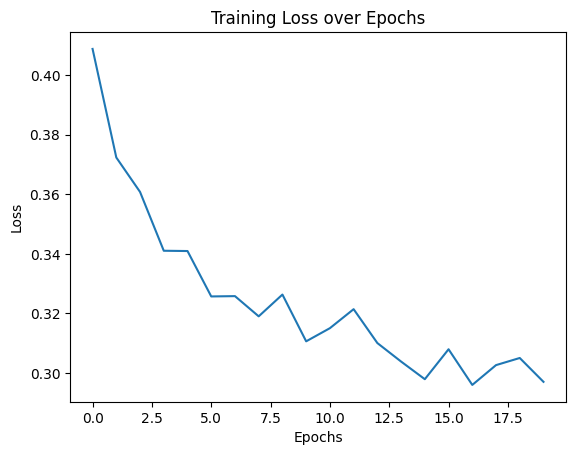

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

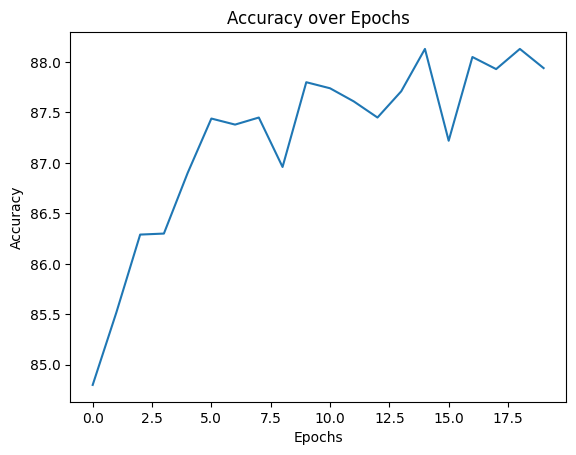

In [ ]:
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 85.35%


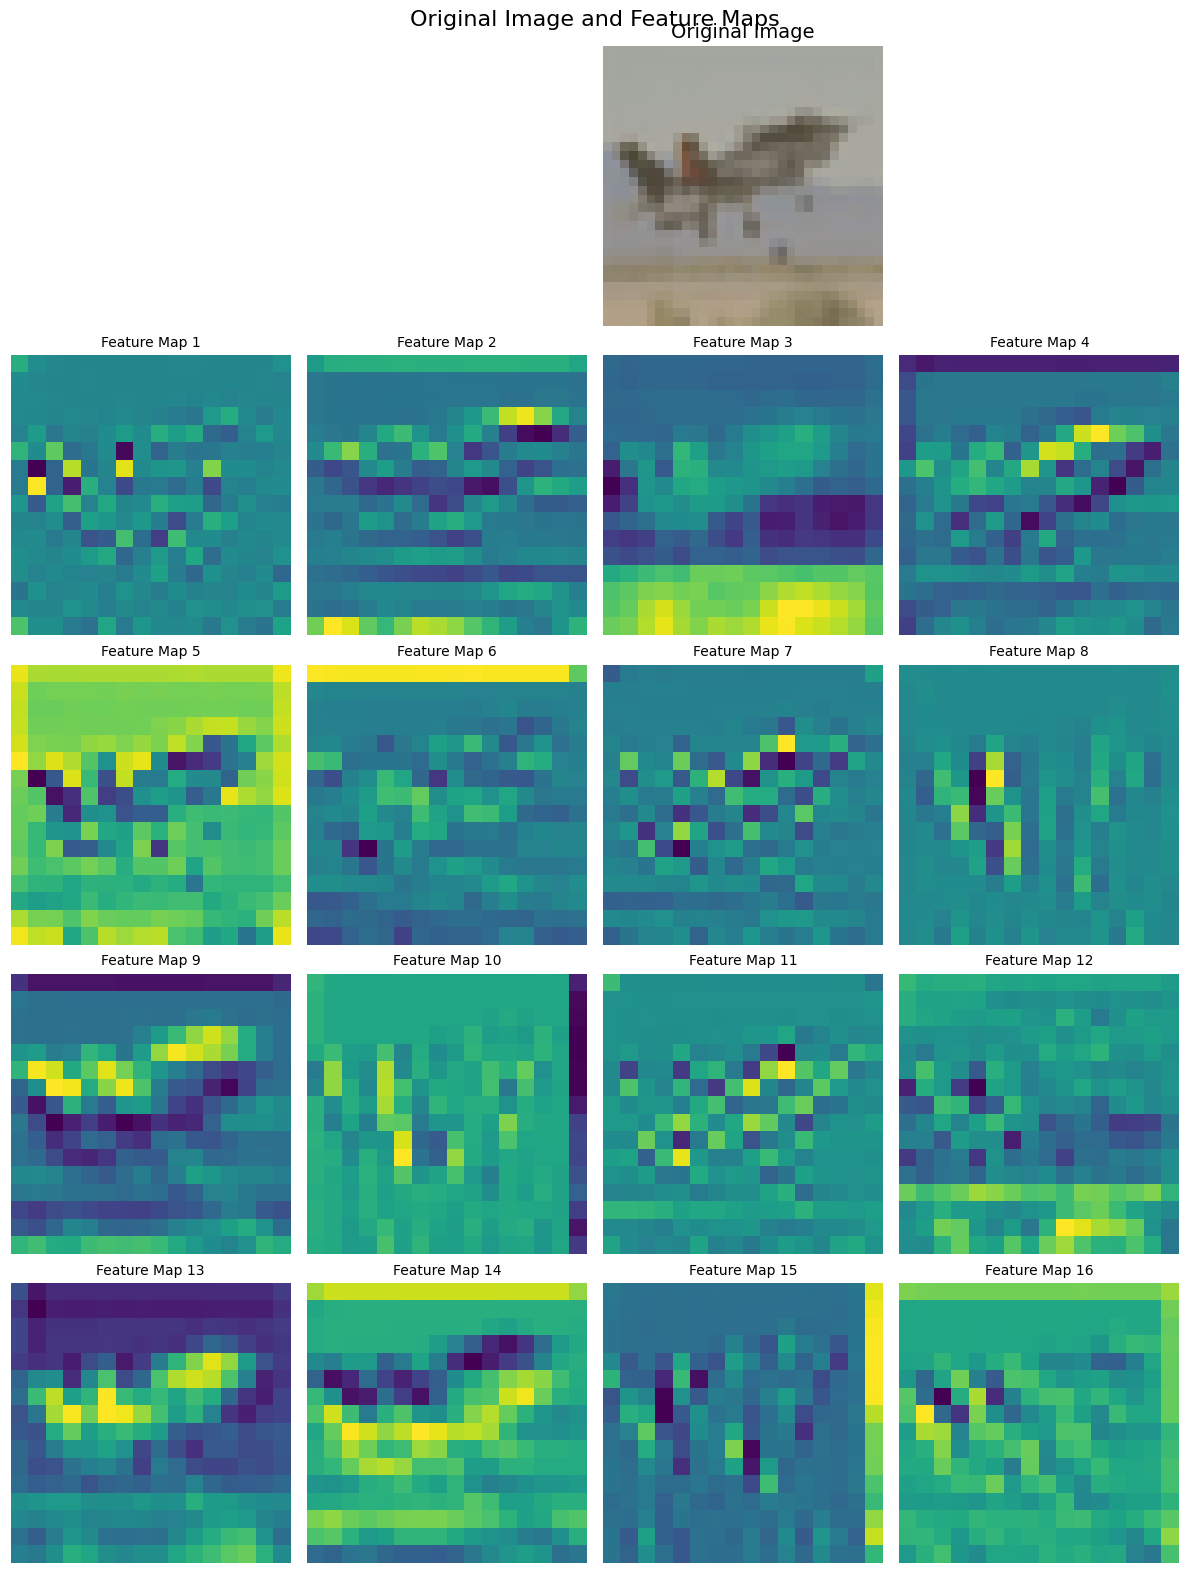

In [ ]:
feature_maps = []
def hook_function(module, input, output):
    feature_maps.append(output)

# Register the hook on a specific layer (e.g., the first convolutional layer)
layer_to_visualize = model.conv1
hook = layer_to_visualize.register_forward_hook(hook_function)

# Pass a batch of inputs through the model to capture feature maps
model.eval()
with torch.no_grad():
    sample_inputs, sample_labels = next(iter(train_loader))
    sample_inputs = sample_inputs.to(device)
    _ = model(sample_inputs)

# Unregister the hook after capturing feature maps
hook.remove()

# Select the first sample and its corresponding feature maps
original_image = sample_inputs[0].cpu()
sample_feature_maps = feature_maps[0][0]
num_feature_maps = sample_feature_maps.size(0)

original_image = inv_transform(original_image)
original_image = np.clip(original_image.permute(1, 2, 0).numpy(), 0, 1)


rows, cols = 4, 4
fig, axes = plt.subplots(rows + 1, cols, figsize=(12, 16))
axes[0, cols // 2].imshow(original_image)
axes[0, cols // 2].set_title("Original Image", fontsize=14)
axes[0, cols // 2].axis('off')
for ax in axes[0]:
    if ax != axes[0, cols // 2]:
        ax.axis('off')

# Plot the feature maps
for i, ax in enumerate(axes[1:].flat):
    if i < num_feature_maps:
        ax.imshow(sample_feature_maps[i].cpu().numpy(), cmap='viridis')
        ax.set_title(f"Feature Map {i+1}", fontsize=10)
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle("Original Image and Feature Maps", fontsize=16)
plt.tight_layout()
plt.show()


# Part 2
# Fine-tuning
In this section, we move on to the fine-tuning phase of our deep learning project. Fine-tuning involves taking the pre-trained model and adapting it to our specific task. here we train the feature extractor of a larger model on our smaller, task-specific dataset, by using the Triplet Loss to help our model differentiate between airplanes and cars more. This enables the model to leverage knowledge gained from the original training while tailoring its capabilities to the nuances our task.

In [7]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, train, selected_classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.cifar10_dataset = datasets.CIFAR10(
            root=self.root_dir,
            train=train,
            download=True,
            transform=transform
        )

        # 'airplane' and 'automobile'
        self.filtered_indices = [i for i in range(len(self.cifar10_dataset.targets)) if self.cifar10_dataset.targets[i] in selected_classes]
        self.filtered_dataset = Subset(self.cifar10_dataset, self.filtered_indices)

    def __getitem__(self, index):
        anchor, anchor_label = self.filtered_dataset[index]

        original_targets = torch.tensor(self.cifar10_dataset.targets)[self.filtered_indices]

        # Select a positive sample
        positive_indices = torch.nonzero(original_targets == anchor_label).squeeze()
        positive_index = np.random.choice(positive_indices.numpy())
        positive, _ = self.filtered_dataset[positive_index]

        # Select a negative sample
        negative_indices = torch.nonzero(original_targets != anchor_label).squeeze()
        negative_index = np.random.choice(negative_indices.numpy())
        negative, _ = self.filtered_dataset[negative_index]

        return anchor, positive, negative, anchor_label

    def __len__(self):
        return len(self.filtered_dataset)


triplet_train_dataset = TripletDataset(
    root_dir='./data',
    train=True,
    selected_classes=selected_classes,
    transform=transform
)
triplet_test_dataset = TripletDataset(
    root_dir='./data',
    train=False,
    selected_classes=selected_classes,
    transform=transform
)

batch_size = 256
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

# Check the dataset sizes
print(f"Number of training examples: {len(filtered_train_dataset)}")
print(f"Number of test examples: {len(filtered_test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 10000
Number of test examples: 2000


In [9]:
# Load pre-trained ResNet-50 model
model2 = models.resnet50(weights='DEFAULT')

model2.fc = nn.Identity() # removing last layer
model2 = model2.to(device)
triplet_loss = nn.TripletMarginLoss()
optimizer    = torch.optim.Adam(model2.parameters(), lr=0.001)


In [ ]:
train_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0
    for anchor, positive, negative, _ in triplet_train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embedding = model2(anchor)
        positive_embedding = model2(positive)
        negative_embedding = model2(negative)
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = epoch_loss / len(triplet_train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.3670
Epoch [2/10], Loss: 0.2075
Epoch [3/10], Loss: 0.1629
Epoch [4/10], Loss: 0.0612
Epoch [5/10], Loss: 0.0259
Epoch [6/10], Loss: 0.0207
Epoch [7/10], Loss: 0.0406
Epoch [8/10], Loss: 0.0220
Epoch [9/10], Loss: 0.0103
Epoch [10/10], Loss: 0.0134


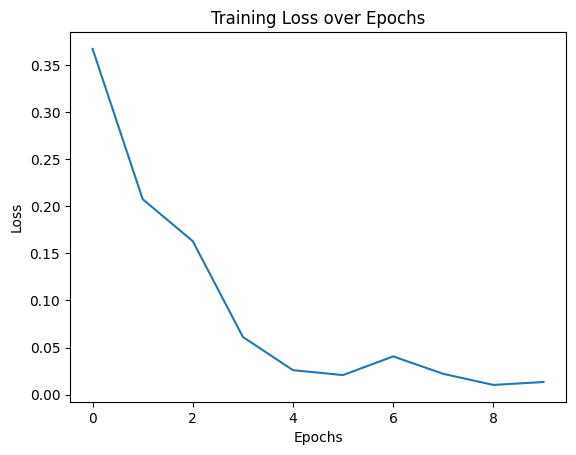

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Freeze params
for param in model2.parameters():
    param.requires_grad = False

model2.fc = nn.Linear(models.resnet50(weights='DEFAULT').fc.in_features, 2)
model2 = model2.to(device)

# Define loss function and optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
train_losses = []
train_accuracies = []
num_epochs=20
for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

Epoch [1/20], Loss: 0.6195, Accuracy: 96.10%
Epoch [2/20], Loss: 0.5132, Accuracy: 99.00%
Epoch [3/20], Loss: 0.4351, Accuracy: 99.13%
Epoch [4/20], Loss: 0.3655, Accuracy: 99.27%
Epoch [5/20], Loss: 0.3137, Accuracy: 99.28%
Epoch [6/20], Loss: 0.2781, Accuracy: 99.35%
Epoch [7/20], Loss: 0.2547, Accuracy: 99.41%
Epoch [8/20], Loss: 0.2161, Accuracy: 99.50%
Epoch [9/20], Loss: 0.1950, Accuracy: 99.46%
Epoch [10/20], Loss: 0.1752, Accuracy: 99.46%
Epoch [11/20], Loss: 0.1573, Accuracy: 99.51%
Epoch [12/20], Loss: 0.1410, Accuracy: 99.45%
Epoch [13/20], Loss: 0.1318, Accuracy: 99.52%
Epoch [14/20], Loss: 0.1220, Accuracy: 99.52%
Epoch [15/20], Loss: 0.1118, Accuracy: 99.56%
Epoch [16/20], Loss: 0.1067, Accuracy: 99.55%
Epoch [17/20], Loss: 0.1050, Accuracy: 99.50%
Epoch [18/20], Loss: 0.0913, Accuracy: 99.46%
Epoch [19/20], Loss: 0.0977, Accuracy: 99.49%
Epoch [20/20], Loss: 0.0935, Accuracy: 99.55%


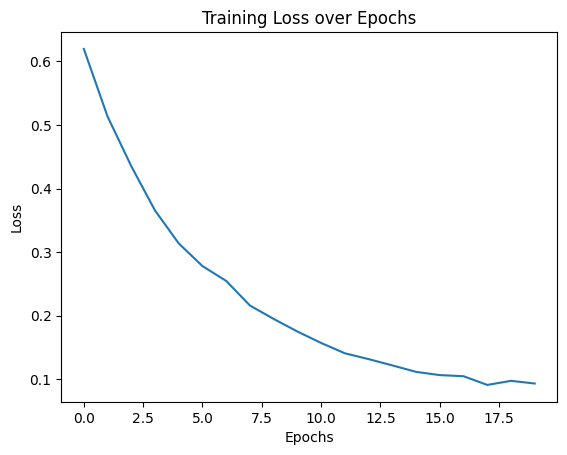

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

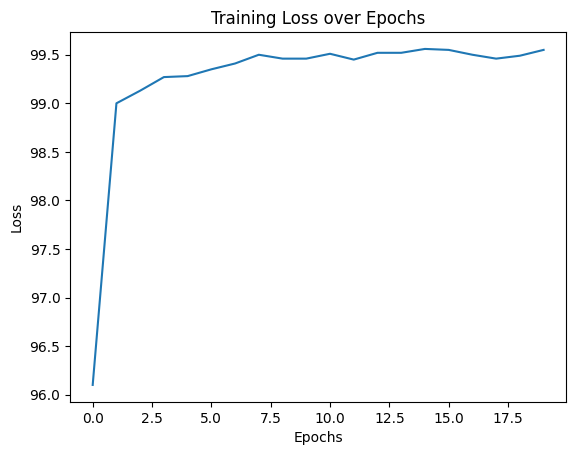

In [ ]:
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
model2.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 97.45%


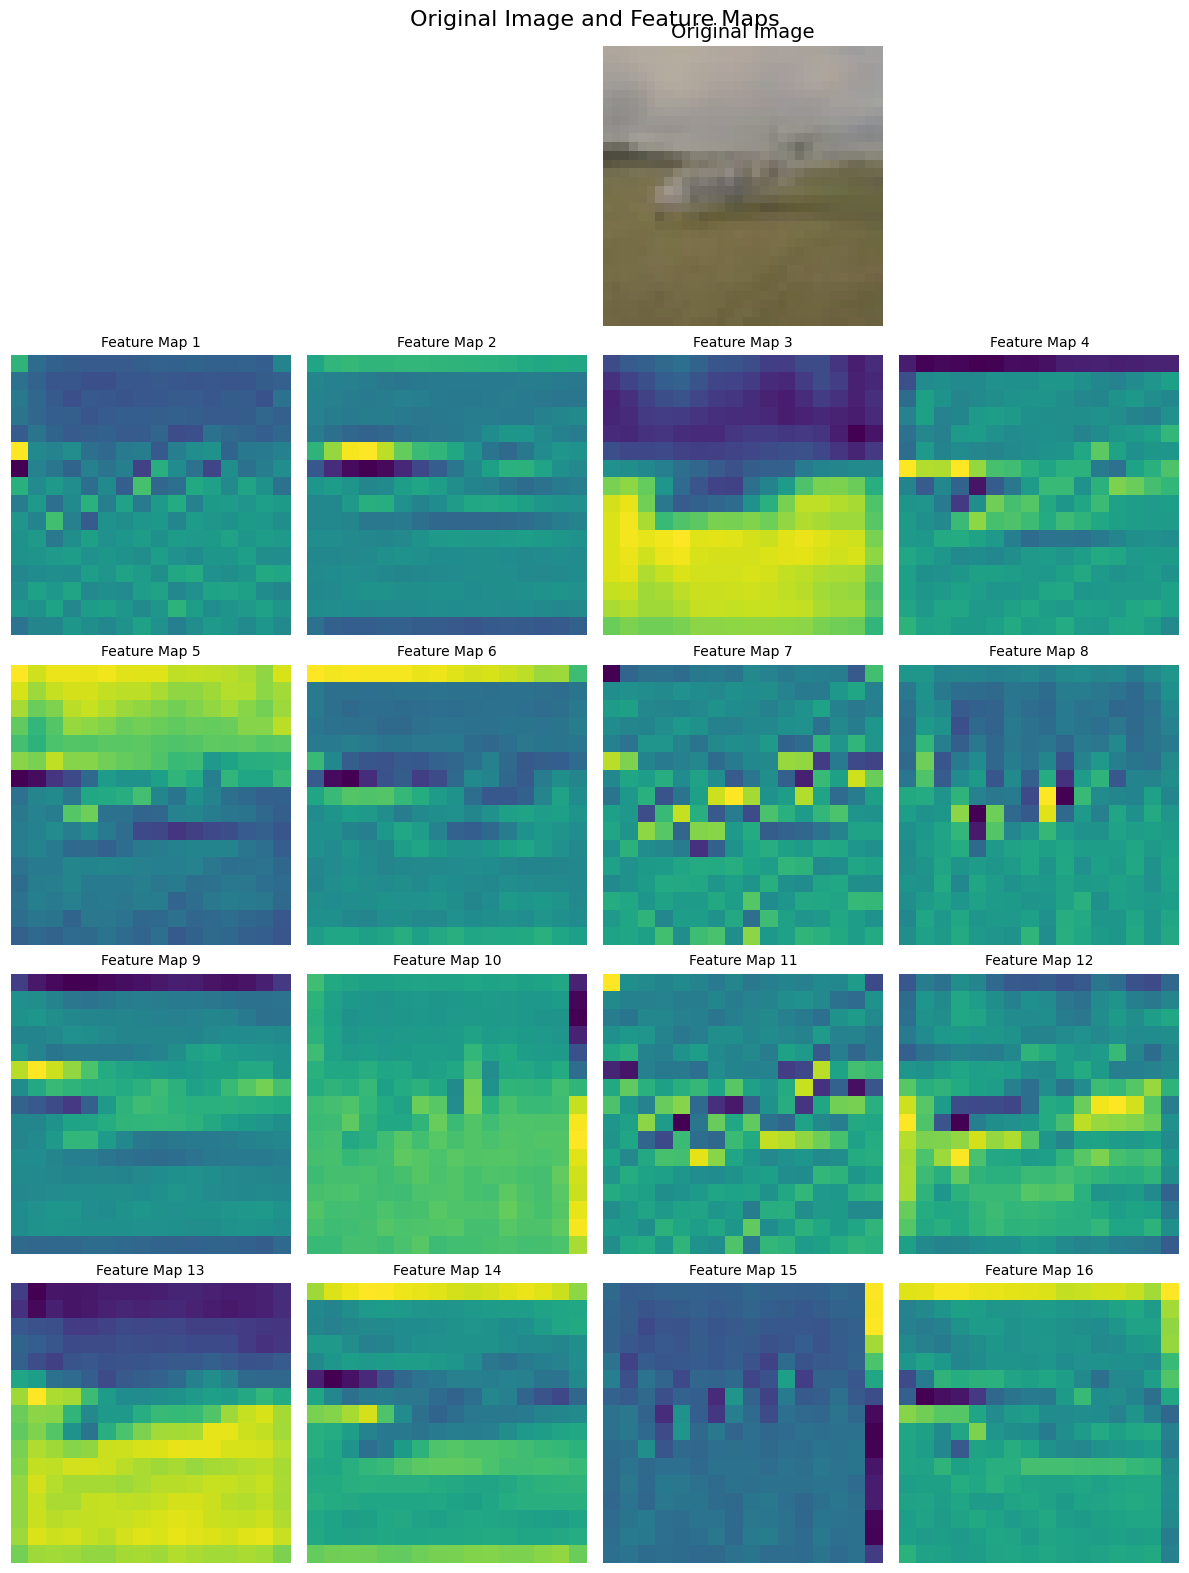

In [ ]:
feature_maps = []
def hook_function(module, input, output):
    feature_maps.append(output)

# Register the hook on a specific layer (e.g., the first convolutional layer)
layer_to_visualize = model2.conv1
hook = layer_to_visualize.register_forward_hook(hook_function)
# Pass a batch of inputs through the model to capture feature maps
model2.eval()
with torch.no_grad():
    sample_inputs, sample_labels = next(iter(train_loader))
    sample_inputs = sample_inputs.to(device)
    _ = model2(sample_inputs)

# Unregister the hook after capturing feature maps
hook.remove()

# Select the first sample and its corresponding feature maps
original_image = sample_inputs[0].cpu()
sample_feature_maps = feature_maps[0][0]
num_feature_maps = sample_feature_maps.size(0)

original_image = inv_transform(original_image)
original_image = np.clip(original_image.permute(1, 2, 0).numpy(), 0, 1)


rows, cols = 4, 4
fig, axes = plt.subplots(rows + 1, cols, figsize=(12, 16))
axes[0, cols // 2].imshow(original_image)
axes[0, cols // 2].set_title("Original Image", fontsize=14)
axes[0, cols // 2].axis('off')
for ax in axes[0]:
    if ax != axes[0, cols // 2]:
        ax.axis('off')

# Plot the feature maps
for i, ax in enumerate(axes[1:].flat):
    if i < num_feature_maps:
        ax.imshow(sample_feature_maps[i].cpu().numpy(), cmap='viridis')
        ax.set_title(f"Feature Map {i+1}", fontsize=10)
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle("Original Image and Feature Maps", fontsize=16)
plt.tight_layout()
plt.show()


# Part 3
### **Why Triplet Loss and Fine-Tuning Can Achieve Better Accuracy than Transfer Learning**

**1. Accuracy Improvement with Triplet Loss and Fine-Tuning**:  
- **Triplet Loss**: This loss function directly optimizes the model to improve the embedding space by minimizing the distance between similar samples (anchor and positive) and maximizing the distance between dissimilar ones (anchor and negative). This leads to better discrimination of features, especially for tasks like face recognition, where fine-grained distinctions matter.
- **Fine-Tuning**: By adapting a pre-trained model to the target task, fine-tuning allows the network to learn domain-specific features that might not be captured during generic transfer learning.

In contrast, transfer learning often freezes earlier layers, relying on pre-trained generic features. These features might not align well with the specific nuances of the new task, potentially limiting accuracy.

---

**2. Convergence Speed**:  
- Triplet loss and fine-tuning may converge more slowly than simple transfer learning because they require the model to re-learn or adjust the embedding space entirely.
- However, fine-tuning leverages pre-trained weights to accelerate convergence compared to training from scratch, offering a balance between speed and task specificity.

---

**3. Feature Maps Difference**:  
- **Transfer Learning**: Feature maps remain largely unchanged in the frozen layers, making them generic and sometimes suboptimal for the target task.
- **Fine-Tuning + Triplet Loss**: Feature maps are updated to better capture task-specific variations, resulting in embeddings that are more compact and discriminative, particularly in high-dimensional spaces.

In summary, triplet loss and fine-tuning lead to better accuracy for tasks requiring precise feature discrimination but might trade off slightly slower convergence for a more optimal embedding space.

# Part 4
# End-to-End Approach
The end-to-end approach involves training a single integrated model, training both the feature extractor with the Triplet Loss and the Linear classifier with the Cross Entropy Loss at the same time to without separating different stages or components, potentially improving model effectiveness.

In [11]:
class EndToEndModel(nn.Module):
    def __init__(self, num_classes):
        super(EndToEndModel, self).__init__()

        # Create feature extractor
        self.feature_extractor = models.resnet50(weights='DEFAULT')
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()

        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.classifier(features)

        return features, predictions

model_e2e = EndToEndModel(2)
model_e2e = model_e2e.to(device)

# Define loss function and optimizer
optimizer    = torch.optim.Adam(model_e2e.parameters(), lr=0.001)
ce_loss   = nn.CrossEntropyLoss()

Epoch 1/10: 100%|██████████| 40/40 [02:17<00:00,  3.44s/it]


Epoch [1/10], Loss: 2.4130, Accuracy: 77.99%


Epoch 2/10: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


Epoch [2/10], Loss: 0.7231, Accuracy: 93.67%


Epoch 3/10: 100%|██████████| 40/40 [02:11<00:00,  3.30s/it]


Epoch [3/10], Loss: 0.3205, Accuracy: 96.54%


Epoch 4/10: 100%|██████████| 40/40 [02:13<00:00,  3.34s/it]


Epoch [4/10], Loss: 0.1396, Accuracy: 98.56%


Epoch 5/10: 100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


Epoch [5/10], Loss: 0.1010, Accuracy: 99.08%


Epoch 6/10: 100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


Epoch [6/10], Loss: 0.0526, Accuracy: 99.61%


Epoch 7/10: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


Epoch [7/10], Loss: 0.1608, Accuracy: 98.33%


Epoch 8/10: 100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


Epoch [8/10], Loss: 0.1068, Accuracy: 99.12%


Epoch 9/10: 100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


Epoch [9/10], Loss: 0.1752, Accuracy: 98.55%


Epoch 10/10: 100%|██████████| 40/40 [02:09<00:00,  3.23s/it]


Epoch [10/10], Loss: 0.2919, Accuracy: 97.16%


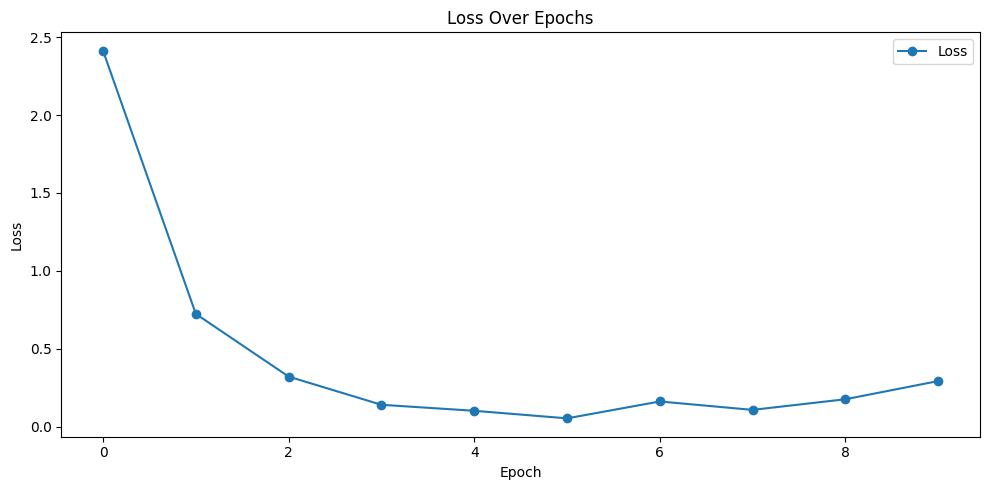

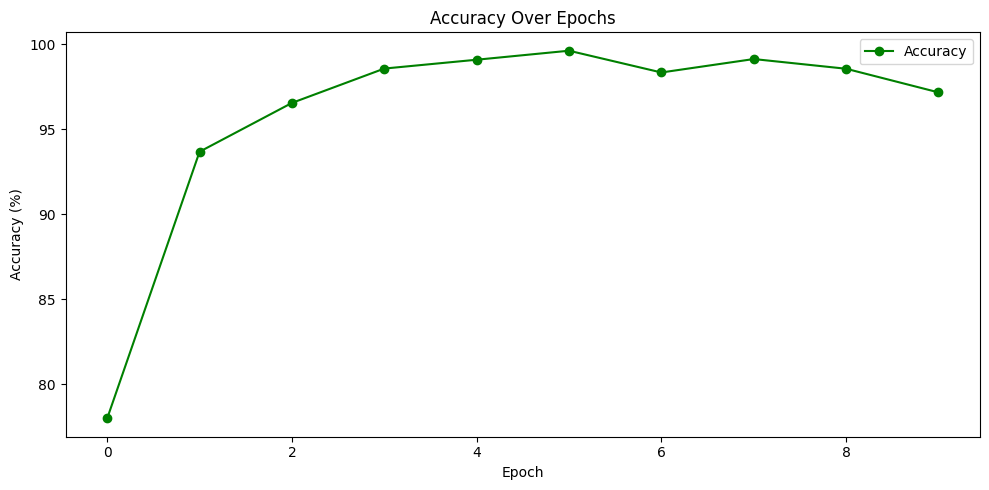

In [14]:
from tqdm import tqdm
train_losses = []
train_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model_e2e.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for anchor, positive, negative, label in tqdm(triplet_train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        anchor, positive, negative, label = anchor.to(device), positive.to(device), negative.to(device), label.to(device)
        optimizer.zero_grad()
        anchor_embedding, pred = model_e2e(anchor)
        positive_embedding, _ = model_e2e(positive)
        negative_embedding, _ = model_e2e(negative)
        loss_tri = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        loss_ce = ce_loss(pred, label)
        loss = loss_tri + loss_ce
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == label).sum().item()
        total_predictions += label.size(0)
    avg_loss = epoch_loss / len(triplet_train_loader)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
accuracy_list = []

model_e2e.eval()

with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    _, outputs = model_e2e(inputs)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    accuracy_list.append(accuracy)

  accuracy = sum(accuracy_list) / len(accuracy_list)

print(f'\nModel accuracy over test dataset: {100*accuracy:.2f}%')

100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


Model accuracy over test dataset: 96.82%


An end-to-end approach that combines Cross-Entropy (CE) loss and Triplet loss outperforms fine-tuning with only Triplet loss and traditional transfer learning due to its ability to optimize complementary objectives simultaneously. CE loss focuses on class-level distinctions by encouraging accurate label predictions, ensuring that features are discriminative across classes. Meanwhile, Triplet loss fine-tunes feature embeddings to maintain intra-class compactness and inter-class separation. When combined in an end-to-end manner, the network learns robust, generalizable features that align well for both classification and embedding tasks, avoiding overfitting to specific feature spaces as might happen with Triplet loss alone. This synergy improves accuracy by addressing diverse aspects of feature learning more comprehensively.